### Setup

In [1]:
import os

import anndata as ad
from mygene import MyGeneInfo
import numpy as np
import pandas as pd

In [2]:
ANN_DATA_DIR = "../data/processed/anndata_orthologs"

EMBEDDINGS = {
    "human_burn": "../data/processed/bulkformer_embeddings/human_burn_transcriptome_embeddings.npy",
    "human_trauma": "../data/processed/bulkformer_embeddings/human_trauma_transcriptome_embeddings.npy",
    "human_sepsis": "../data/processed/bulkformer_embeddings/human_sepsis_transcriptome_embeddings.npy",
    "mouse_burn": "../data/processed/bulkformer_embeddings/mouse_burn_transcriptome_embeddings.npy",
    "mouse_trauma": "../data/processed/bulkformer_embeddings/mouse_trauma_transcriptome_embeddings.npy",
    "mouse_sepsis": "../data/processed/bulkformer_embeddings/mouse_sepsis_transcriptome_embeddings.npy",
    "mouse_infection": "../data/processed/bulkformer_embeddings/mouse_infection_transcriptome_embeddings.npy",
}

In [3]:
# load adatas
adatas = {}
for f in sorted(os.listdir(ANN_DATA_DIR)):
    if f.endswith(".h5ad"):
        name = f.replace("_orthologs.h5ad", "")
        path = os.path.join(ANN_DATA_DIR, f)
        adatas[name] = ad.read_h5ad(path)
        print(f"Loaded {name}: {adatas[name].shape}")

        # add embeddings to adata
        embedding = np.load(EMBEDDINGS[name])
        adatas[name].obsm["X_bulkformer"] = embedding

adatas

Loaded human_burn: (590, 19914)
Loaded human_sepsis: (30, 19914)
Loaded human_trauma: (857, 19914)
Loaded mouse_burn: (32, 13833)
Loaded mouse_infection: (72, 10248)
Loaded mouse_sepsis: (50, 13833)
Loaded mouse_trauma: (96, 13833)


{'human_burn': AnnData object with n_obs × n_vars = 590 × 19914
     obs: 'group', 'patient_id', 'tissue', 'sex', 'age', 'time_point_hours', 'qc_flag'
     var: 'symbol'
     uns: 'provenance'
     obsm: 'X_bulkformer',
 'human_sepsis': AnnData object with n_obs × n_vars = 30 × 19914
     obs: 'tissue', 'group', 'qc_flag'
     var: 'symbol'
     uns: 'provenance'
     obsm: 'X_bulkformer',
 'human_trauma': AnnData object with n_obs × n_vars = 857 × 19914
     obs: 'group', 'patient_id', 'tissue', 'sex', 'age', 'time_point_hours', 'qc_flag'
     var: 'symbol'
     uns: 'provenance'
     obsm: 'X_bulkformer',
 'mouse_burn': AnnData object with n_obs × n_vars = 32 × 13833
     obs: 'title', 'cell_type', 'qc_flag', 'sex', 'strain', 'time_point_hours', 'group', 'patient_id'
     var: 'symbol', 'human_ensembl'
     uns: 'provenance'
     obsm: 'X_bulkformer',
 'mouse_infection': AnnData object with n_obs × n_vars = 72 × 10248
     obs: 'age', 'strain', 'qc_flag', 'infection_status_detail', '

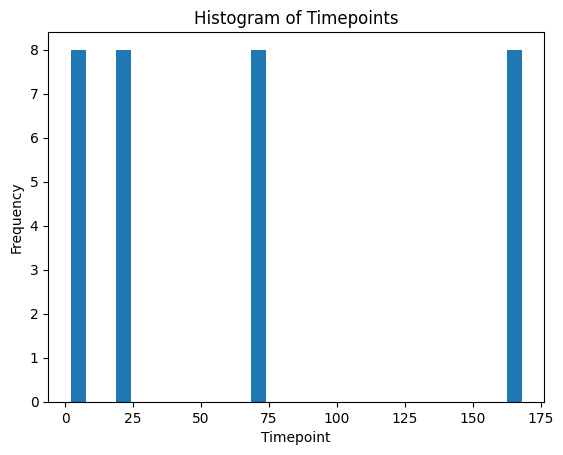

In [4]:
# plot histogram of timepoints
import matplotlib.pyplot as plt

dataset = "mouse_burn"

plt.hist(adatas[dataset].obs["time_point_hours"], bins=30)
plt.xlabel("Timepoint")
plt.ylabel("Frequency")
plt.title("Histogram of Timepoints")
plt.show()

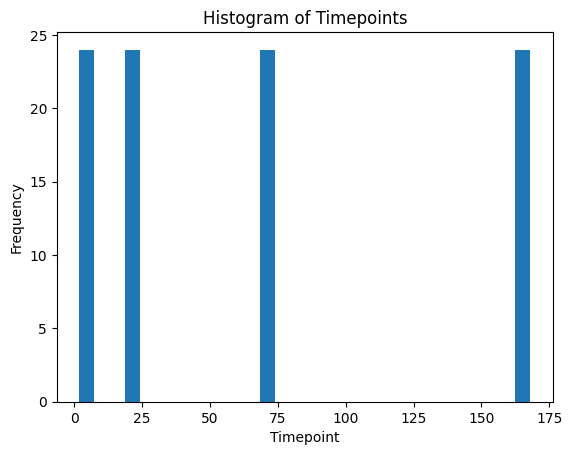

In [5]:
# plot histogram of timepoints
import matplotlib.pyplot as plt

dataset = "mouse_trauma"

plt.hist(adatas[dataset].obs["time_point_hours"], bins=30)
plt.xlabel("Timepoint")
plt.ylabel("Frequency")
plt.title("Histogram of Timepoints")
plt.show()

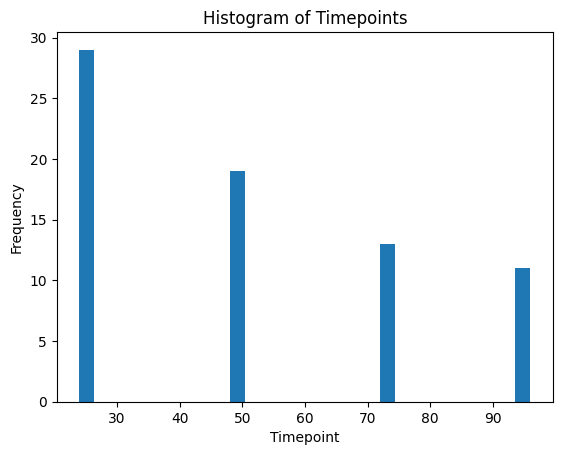

In [6]:
# plot histogram of timepoints
import matplotlib.pyplot as plt

dataset = "mouse_infection"

plt.hist(adatas[dataset].obs["time_point_hours"], bins=30)
plt.xlabel("Timepoint")
plt.ylabel("Frequency")
plt.title("Histogram of Timepoints")
plt.show()

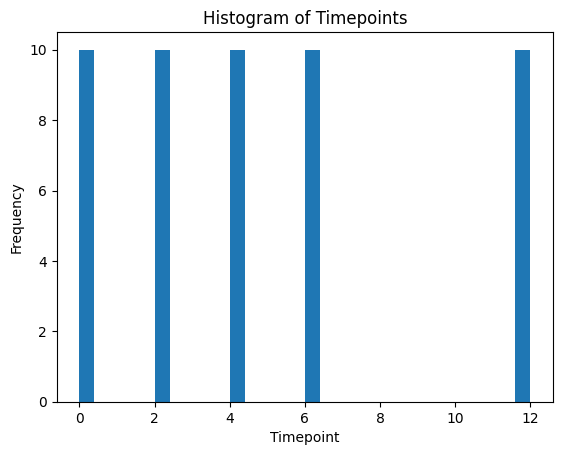

In [7]:
# plot histogram of timepoints
import matplotlib.pyplot as plt

dataset = "mouse_sepsis"

plt.hist(adatas[dataset].obs["time_point"], bins=30)
plt.xlabel("Timepoint")
plt.ylabel("Frequency")
plt.title("Histogram of Timepoints")
plt.show()

### Clean datasets

In [8]:
HUMAN_ACUTE_CUTOFF_HOURS = 24
HUMAN_SUBACUTE_CUTOFF_HOURS = 7 * 24
MOUSE_ACUTE_CUTOFF_HOURS = 12
MOUSE_SUBACUTE_CUTOFF_HOURS = 55


def fill_and_transform_infl_categories(adatas):
    """Fill and transform inflammation categories for all adatas."""
    for adata in adatas.values():
        if "infl_acute" not in adata.obs.columns:
            continue
        # set infl_acute column type to boolean
        adata.obs["infl_acute"].fillna(False, inplace=True)
        adata.obs["infl_acute"] = adata.obs["infl_acute"].astype(bool)

        adata.obs["infl_subacute"].fillna(False, inplace=True)
        adata.obs["infl_subacute"] = adata.obs["infl_subacute"].astype(bool)

        adata.obs["infl_chronic"].fillna(False, inplace=True)
        adata.obs["infl_chronic"] = adata.obs["infl_chronic"].astype(bool)


# -------- Human Burn ------------
adatas["human_burn"].obs["age"] = pd.to_numeric(adatas["human_burn"].obs["age"], errors="coerce")
adatas["human_burn"].obs.loc[
    adatas["human_burn"].obs["group"] == "control", "time_point_hours"
] = pd.NA
adatas["human_burn"].obs["takao_inflamed"] = adatas["human_burn"].obs["group"] == "inflammation"
adatas["human_burn"].obs["takao_control"] = adatas["human_burn"].obs["group"] == "control"
adatas["human_burn"].obs["takao_status"] = pd.NA
adatas["human_burn"].obs.loc[adatas["human_burn"].obs["takao_inflamed"], "takao_status"] = (
    "takao_inflamed"
)
adatas["human_burn"].obs.loc[adatas["human_burn"].obs["takao_control"], "takao_status"] = (
    "takao_control"
)
adatas["human_burn"].obs["takao_status"] = (
    adatas["human_burn"].obs["takao_status"].astype("category")
)
adatas["human_burn"].obs["infl_acute"] = (adatas["human_burn"].obs["group"] != "control") & (
    adatas["human_burn"].obs["time_point_hours"] < (HUMAN_ACUTE_CUTOFF_HOURS)
)
adatas["human_burn"].obs["infl_subacute"] = (
    (adatas["human_burn"].obs["group"] != "control")
    & (adatas["human_burn"].obs["time_point_hours"] >= (HUMAN_ACUTE_CUTOFF_HOURS))
    & (adatas["human_burn"].obs["time_point_hours"] < (HUMAN_SUBACUTE_CUTOFF_HOURS))
)
adatas["human_burn"].obs["infl_chronic"] = (adatas["human_burn"].obs["group"] != "control") & (
    adatas["human_burn"].obs["time_point_hours"] >= (HUMAN_SUBACUTE_CUTOFF_HOURS)
)

# -------- Human Trauma ------------
adatas["human_trauma"].obs["age"] = pd.to_numeric(
    adatas["human_trauma"].obs["age"], errors="coerce"
)
adatas["human_trauma"].obs["takao_inflamed"] = (
    adatas["human_trauma"].obs["group"] == "inflammation"
) & (adatas["human_trauma"].obs["time_point_hours"] > (14 * 24))
adatas["human_trauma"].obs["takao_control"] = adatas["human_trauma"].obs["group"] == "control"
adatas["human_trauma"].obs["takao_status"] = pd.NA
adatas["human_trauma"].obs.loc[adatas["human_trauma"].obs["takao_inflamed"], "takao_status"] = (
    "takao_inflamed"
)
adatas["human_trauma"].obs.loc[adatas["human_trauma"].obs["takao_control"], "takao_status"] = (
    "takao_control"
)
adatas["human_trauma"].obs.loc[
    adatas["human_trauma"].obs["group"] == "control", "time_point_hours"
] = pd.NA
adatas["human_trauma"].obs["takao_status"] = (
    adatas["human_trauma"].obs["takao_status"].astype("category")
)
adatas["human_trauma"].obs["infl_acute"] = (adatas["human_trauma"].obs["group"] != "control") & (
    adatas["human_trauma"].obs["time_point_hours"] <= HUMAN_ACUTE_CUTOFF_HOURS
)
adatas["human_trauma"].obs["infl_subacute"] = (
    (adatas["human_trauma"].obs["group"] != "control")
    & (adatas["human_trauma"].obs["time_point_hours"] > (HUMAN_ACUTE_CUTOFF_HOURS))
    & (adatas["human_trauma"].obs["time_point_hours"] <= (HUMAN_SUBACUTE_CUTOFF_HOURS))
)
adatas["human_trauma"].obs["infl_chronic"] = (adatas["human_trauma"].obs["group"] != "control") & (
    adatas["human_trauma"].obs["time_point_hours"] > (HUMAN_SUBACUTE_CUTOFF_HOURS)
)

# -------- Human Sepsis ------------
adatas["human_sepsis"].obs["takao_inflamed"] = (
    adatas["human_sepsis"].obs["group"] == "inflammation"
)
adatas["human_sepsis"].obs["takao_control"] = adatas["human_sepsis"].obs["group"] == "control"
adatas["human_sepsis"].obs["takao_status"] = pd.NA
adatas["human_sepsis"].obs.loc[adatas["human_sepsis"].obs["takao_inflamed"], "takao_status"] = (
    "takao_inflamed"
)
adatas["human_sepsis"].obs.loc[adatas["human_sepsis"].obs["takao_control"], "takao_status"] = (
    "takao_control"
)
adatas["human_sepsis"].obs["takao_status"] = (
    adatas["human_sepsis"].obs["takao_status"].astype("category")
)

# -------- Mouse Burn ------------
adatas["mouse_burn"].obs["takao_inflamed"] = (
    adatas["mouse_burn"].obs["group"] == "inflammation"
) & (adatas["mouse_burn"].obs["time_point_hours"] >= 150)
adatas["mouse_burn"].obs["takao_control"] = adatas["mouse_burn"].obs["group"] == "control"
adatas["mouse_burn"].obs["takao_status"] = pd.NA
adatas["mouse_burn"].obs.loc[adatas["mouse_burn"].obs["takao_inflamed"], "takao_status"] = (
    "takao_inflamed"
)
adatas["mouse_burn"].obs.loc[adatas["mouse_burn"].obs["takao_control"], "takao_status"] = (
    "takao_control"
)
adatas["mouse_burn"].obs.loc[
    adatas["mouse_burn"].obs["group"] == "control", "time_point_hours"
] = pd.NA
adatas["mouse_burn"].obs["takao_status"] = (
    adatas["mouse_burn"].obs["takao_status"].astype("category")
)
adatas["mouse_burn"].obs["infl_acute"] = (adatas["mouse_burn"].obs["group"] != "control") & (
    adatas["mouse_burn"].obs["time_point_hours"] < (MOUSE_ACUTE_CUTOFF_HOURS)
)
adatas["mouse_burn"].obs["infl_subacute"] = (
    (adatas["mouse_burn"].obs["group"] != "control")
    & (adatas["mouse_burn"].obs["time_point_hours"] >= (MOUSE_ACUTE_CUTOFF_HOURS))
    & (adatas["mouse_burn"].obs["time_point_hours"] < (MOUSE_SUBACUTE_CUTOFF_HOURS))
)
adatas["mouse_burn"].obs["infl_chronic"] = (adatas["mouse_burn"].obs["group"] != "control") & (
    adatas["mouse_burn"].obs["time_point_hours"] >= (MOUSE_SUBACUTE_CUTOFF_HOURS)
)

# -------- Mouse Trauma ------------
adatas["mouse_trauma"].obs["takao_inflamed"] = (
    adatas["mouse_trauma"].obs["group"] == "inflammation"
) & (adatas["mouse_trauma"].obs["time_point_hours"] > 72)
adatas["mouse_trauma"].obs["takao_control"] = adatas["mouse_trauma"].obs["group"] == "control"
adatas["mouse_trauma"].obs["takao_status"] = pd.NA
adatas["mouse_trauma"].obs.loc[adatas["mouse_trauma"].obs["takao_inflamed"], "takao_status"] = (
    "takao_inflamed"
)
adatas["mouse_trauma"].obs.loc[adatas["mouse_trauma"].obs["takao_control"], "takao_status"] = (
    "takao_control"
)
adatas["mouse_trauma"].obs.loc[
    adatas["mouse_trauma"].obs["group"] == "control", "time_point_hours"
] = pd.NA
adatas["mouse_trauma"].obs["takao_status"] = (
    adatas["mouse_trauma"].obs["takao_status"].astype("category")
)
adatas["mouse_trauma"].obs["infl_acute"] = (adatas["mouse_trauma"].obs["group"] != "control") & (
    adatas["mouse_trauma"].obs["time_point_hours"] < (MOUSE_ACUTE_CUTOFF_HOURS)
)
adatas["mouse_trauma"].obs["infl_subacute"] = (
    (adatas["mouse_trauma"].obs["group"] != "control")
    & (adatas["mouse_trauma"].obs["time_point_hours"] >= (MOUSE_ACUTE_CUTOFF_HOURS))
    & (adatas["mouse_trauma"].obs["time_point_hours"] < (MOUSE_SUBACUTE_CUTOFF_HOURS))
)
adatas["mouse_trauma"].obs["infl_chronic"] = (adatas["mouse_trauma"].obs["group"] != "control") & (
    adatas["mouse_trauma"].obs["time_point_hours"] >= (MOUSE_SUBACUTE_CUTOFF_HOURS)
)

# -------- Mouse Sepsis ------------
adatas["mouse_sepsis"].obs["takao_inflamed"] = (
    (adatas["mouse_sepsis"].obs["group"] == "inflammation")
    & (adatas["mouse_sepsis"].obs["time_point"] == 4.0)
    & (adatas["mouse_sepsis"].obs["strain"] == "C57BL/6J")
)
adatas["mouse_sepsis"].obs["takao_control"] = (
    adatas["mouse_sepsis"].obs["group"] == "control"
) & (adatas["mouse_sepsis"].obs["strain"] == "C57BL/6J")
adatas["mouse_sepsis"].obs["takao_status"] = pd.NA
adatas["mouse_sepsis"].obs.loc[adatas["mouse_sepsis"].obs["takao_inflamed"], "takao_status"] = (
    "takao_inflamed"
)
adatas["mouse_sepsis"].obs.loc[adatas["mouse_sepsis"].obs["takao_control"], "takao_status"] = (
    "takao_control"
)
adatas["mouse_sepsis"].obs.loc[adatas["mouse_sepsis"].obs["group"] == "control", "time_point"] = (
    pd.NA
)
adatas["mouse_sepsis"].obs["takao_status"] = (
    adatas["mouse_sepsis"].obs["takao_status"].astype("category")
)
adatas["mouse_sepsis"].obs["time_point_hours"] = adatas["mouse_sepsis"].obs["time_point"]
adatas["mouse_sepsis"].obs = adatas["mouse_sepsis"].obs.drop(columns=["time_point"])
adatas["mouse_sepsis"].obs["infl_acute"] = (adatas["mouse_sepsis"].obs["group"] != "control") & (
    adatas["mouse_sepsis"].obs["time_point_hours"] < (MOUSE_ACUTE_CUTOFF_HOURS)
)
adatas["mouse_sepsis"].obs["infl_subacute"] = (
    (adatas["mouse_sepsis"].obs["group"] != "control")
    & (adatas["mouse_sepsis"].obs["time_point_hours"] >= (MOUSE_ACUTE_CUTOFF_HOURS))
    & (adatas["mouse_sepsis"].obs["time_point_hours"] < (MOUSE_SUBACUTE_CUTOFF_HOURS))
)
adatas["mouse_sepsis"].obs["infl_chronic"] = (adatas["mouse_sepsis"].obs["group"] != "control") & (
    adatas["mouse_sepsis"].obs["time_point_hours"] >= (MOUSE_SUBACUTE_CUTOFF_HOURS)
)

# -------- Mouse Infection ------------
adatas["mouse_infection"].obs["takao_inflamed"] = (
    (adatas["mouse_infection"].obs["group"] == "inflammation")
    & (adatas["mouse_infection"].obs["time_point_hours"] == 24)
    & (adatas["mouse_infection"].obs["infection_status_detail"] == "candida")
)
adatas["mouse_infection"].obs["takao_control"] = (
    adatas["mouse_infection"].obs["group"] == "control"
)
adatas["mouse_infection"].obs["takao_status"] = pd.NA
adatas["mouse_infection"].obs.loc[
    adatas["mouse_infection"].obs["takao_inflamed"], "takao_status"
] = "takao_inflamed"
adatas["mouse_infection"].obs.loc[
    adatas["mouse_infection"].obs["takao_control"], "takao_status"
] = "takao_control"
adatas["mouse_infection"].obs.loc[
    adatas["mouse_infection"].obs["group"] == "control", "time_point_hours"
] = pd.NA
adatas["mouse_infection"].obs["takao_status"] = (
    adatas["mouse_infection"].obs["takao_status"].astype("category")
)
adatas["mouse_infection"].obs["infl_acute"] = (
    adatas["mouse_infection"].obs["group"] != "control"
) & (adatas["mouse_infection"].obs["time_point_hours"] < (MOUSE_ACUTE_CUTOFF_HOURS))
adatas["mouse_infection"].obs["infl_subacute"] = (
    (adatas["mouse_infection"].obs["group"] != "control")
    & (adatas["mouse_infection"].obs["time_point_hours"] >= (MOUSE_ACUTE_CUTOFF_HOURS))
    & (adatas["mouse_infection"].obs["time_point_hours"] < (MOUSE_SUBACUTE_CUTOFF_HOURS))
)
adatas["mouse_infection"].obs["infl_chronic"] = (
    adatas["mouse_infection"].obs["group"] != "control"
) & (adatas["mouse_infection"].obs["time_point_hours"] >= (MOUSE_SUBACUTE_CUTOFF_HOURS))

fill_and_transform_infl_categories(adatas)

/tmp/ipykernel_1937651/147843137.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs["infl_acute"].fillna(False, inplace=True)
/tmp/ipykernel_1937651/147843137.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [9]:
# add embeddings as obsm to each anndata
for name, adata in adatas.items():
    embedding = np.load(EMBEDDINGS[name])
    adata.obsm["X_bulkformer"] = embedding

In [10]:
# save all adatas
for name, adata in adatas.items():
    save_path = os.path.join("../data/processed/anndata_combined", f"{name}.h5ad")
    adata.write_h5ad(save_path)
    print(f"Saved {name} with embeddings to {save_path}")

Saved human_burn with embeddings to ../data/processed/anndata_combined/human_burn.h5ad
Saved human_sepsis with embeddings to ../data/processed/anndata_combined/human_sepsis.h5ad
Saved human_trauma with embeddings to ../data/processed/anndata_combined/human_trauma.h5ad
Saved mouse_burn with embeddings to ../data/processed/anndata_combined/mouse_burn.h5ad
Saved mouse_infection with embeddings to ../data/processed/anndata_combined/mouse_infection.h5ad
Saved mouse_sepsis with embeddings to ../data/processed/anndata_combined/mouse_sepsis.h5ad
Saved mouse_trauma with embeddings to ../data/processed/anndata_combined/mouse_trauma.h5ad


### Combine mouse and human datasets separately

In [11]:
# combine all human and mouse adatas separately
human_adatas = [adatas[k] for k in adatas if k.startswith("human")]
mouse_adatas = [adatas[k] for k in adatas if k.startswith("mouse")]

# concatenate
human_adata_combined = ad.concat(
    human_adatas, join="outer", label="dataset", keys=[k for k in adatas if k.startswith("human")]
)
mouse_adata_combined = ad.concat(
    mouse_adatas, join="outer", label="dataset", keys=[k for k in adatas if k.startswith("mouse")]
)

In [12]:
human_adata_combined.obs

,group,patient_id,tissue,sex,age,time_point_hours,qc_flag,takao_inflamed,takao_control,takao_status,infl_acute,infl_subacute,infl_chronic,dataset
GSM909644,control,19297865.0,White Blood Cells,F,30.0,NaN,0,False,True,takao_control,False,False,False,human_burn
GSM909645,control,35028656.0,White Blood Cells,M,35.0,NaN,0,False,True,takao_control,False,False,False,human_burn
GSM909646,control,16952213.0,White Blood Cells,F,30.0,NaN,0,False,True,takao_control,False,False,False,human_burn
GSM909647,control,20591195.0,White Blood Cells,M,19.0,NaN,0,False,True,takao_control,False,False,False,human_burn
GSM909648,control,19107727.0,White Blood Cells,F,18.0,NaN,1,False,True,takao_control,False,False,False,human_burn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM902165,inflammation,9754329.0,White Blood Cells,F,48.0,83.6,0,False,False,NaN,False,True,False,human_trauma
GSM902166,inflammation,9973279.0,White Blood Cells,F,44.0,162.6,0,False,False,NaN,False,True,False,human_trauma
GSM902167,inflammation,9973279.0,White Blood Cells,F,44.0,22.7,0,False,False,NaN,True,False,False,human_trauma
GSM902168,inflammation,9973279.0,White Blood Cells,F,44.0,5.4,0,False,False,NaN,True,False,False,human_trauma


In [13]:
mouse_adata_combined.obs

,title,cell_type,qc_flag,sex,strain,time_point_hours,group,patient_id,takao_inflamed,takao_control,takao_status,infl_acute,infl_subacute,infl_chronic,age,infection_status_detail,tissue,dataset
GSM178608,Burn Blood 2 hr rep 1,mouse leukocytes,0,Male,C57BL/6J,2.0,inflammation,1.0,False,False,NaN,True,False,False,NaN,NaN,NaN,mouse_burn
GSM178609,Burn Blood 2 hr rep 2,mouse leukocytes,0,Male,C57BL/6J,2.0,inflammation,2.0,False,False,NaN,True,False,False,NaN,NaN,NaN,mouse_burn
GSM178610,Burn Blood 2 hr rep 3,mouse leukocytes,1,Male,C57BL/6J,2.0,inflammation,3.0,False,False,NaN,True,False,False,NaN,NaN,NaN,mouse_burn
GSM178611,Burn Blood 2 hr rep 4,mouse leukocytes,0,Male,C57BL/6J,2.0,inflammation,4.0,False,False,NaN,True,False,False,NaN,NaN,NaN,mouse_burn
GSM178612,Burn Blood 1 day rep 1,mouse leukocytes,0,Male,C57BL/6J,24.0,inflammation,1.0,False,False,NaN,False,True,False,NaN,NaN,NaN,mouse_burn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM178731,Trauma Hemorrhage Sham Spleen 3 day rep 4,mouse splenocytes,0,Male,C57BL/6J,NaN,control,4.0,False,True,takao_control,False,False,False,NaN,NaN,NaN,mouse_trauma
GSM178732,Trauma Hemorrhage Sham Spleen 7 day rep 1,mouse splenocytes,0,Male,C57BL/6J,NaN,control,1.0,False,True,takao_control,False,False,False,NaN,NaN,NaN,mouse_trauma
GSM178733,Trauma Hemorrhage Sham Spleen 7 day rep 2,mouse splenocytes,0,Male,C57BL/6J,NaN,control,2.0,False,True,takao_control,False,False,False,NaN,NaN,NaN,mouse_trauma
GSM178734,Trauma Hemorrhage Sham Spleen 7 day rep 3,mouse splenocytes,0,Male,C57BL/6J,NaN,control,3.0,False,True,takao_control,False,False,False,NaN,NaN,NaN,mouse_trauma


In [14]:
mg = MyGeneInfo()
result = mg.querymany(
    human_adata_combined.var_names.tolist(),
    scopes="ensembl.gene",
    fields="symbol",
    species="human",
)

result

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
4 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000228044', 2), ('ENSG00000234352', 2), ('ENSG00000250406', 2)]
124 input query terms found no hit:	['ENSG00000002079', 'ENSG00000112096', 'ENSG00000130723', 'ENSG00000146521', 'ENSG00000148362', 'ENS


[{'query': 'ENSG00000000003',
  '_id': '7105',
  '_score': 32.910175,
  'symbol': 'TSPAN6'},
 {'query': 'ENSG00000000005',
  '_id': '64102',
  '_score': 32.910175,
  'symbol': 'TNMD'},
 {'query': 'ENSG00000000419',
  '_id': '8813',
  '_score': 32.910175,
  'symbol': 'DPM1'},
 {'query': 'ENSG00000000457',
  '_id': '57147',
  '_score': 32.910175,
  'symbol': 'SCYL3'},
 {'query': 'ENSG00000000460',
  '_id': '55732',
  '_score': 32.910175,
  'symbol': 'FIRRM'},
 {'query': 'ENSG00000000938',
  '_id': '2268',
  '_score': 32.910175,
  'symbol': 'FGR'},
 {'query': 'ENSG00000000971',
  '_id': '3075',
  '_score': 32.910175,
  'symbol': 'CFH'},
 {'query': 'ENSG00000001036',
  '_id': '2519',
  '_score': 32.910175,
  'symbol': 'FUCA2'},
 {'query': 'ENSG00000001084',
  '_id': '2729',
  '_score': 32.910175,
  'symbol': 'GCLC'},
 {'query': 'ENSG00000001167',
  '_id': '4800',
  '_score': 32.910175,
  'symbol': 'NFYA'},
 {'query': 'ENSG00000001460',
  '_id': '90529',
  '_score': 32.910175,
  'symbol': '

In [15]:
# Convert MyGeneInfo result (list of dicts) into DataFrame
res_df = pd.DataFrame(result)

# Extract valid mappings (drop rows missing 'symbol')
mapping = res_df[["query", "symbol"]].dropna(subset=["symbol"]).drop_duplicates(subset="query")

# Create dict: Ensembl gene ID → Gene Symbol
symbol_map = dict(zip(mapping["query"], mapping["symbol"]))

# Add columns to .var
human_adata_combined.var["Gene"] = human_adata_combined.var_names
human_adata_combined.var["Symbol"] = human_adata_combined.var["Gene"].map(symbol_map)

# Fill missing symbols with original gene IDs
human_adata_combined.var["Symbol"] = human_adata_combined.var["Symbol"].fillna(
    human_adata_combined.var["Gene"]
)


# --- Safe deduplication (pandas ≥ 2.0 compatible) ---
def deduplicate_names(names):
    seen = {}
    deduped = []
    for n in names:
        if n not in seen:
            seen[n] = 0
            deduped.append(n)
        else:
            seen[n] += 1
            deduped.append(f"{n}.{seen[n]}")
    return deduped


human_adata_combined.var["Symbol"] = deduplicate_names(human_adata_combined.var["Symbol"].tolist())

# Finally, set as var_names
human_adata_combined.var_names = human_adata_combined.var["Symbol"]

human_adata_combined.var_names

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'LOC101929116', 'C3orf36', 'ENSG00000288559', 'LINC01949',
       'ENSG00000288573', 'ENSG00000288586', 'NPBWR1', 'ENSG00000288612',
       'RNF228', 'ENSG00000288670'],
      dtype='object', name='Symbol', length=19914)

In [16]:
human_adata_combined.var

,Gene,Symbol
Symbol,,
TSPAN6,ENSG00000000003,TSPAN6
TNMD,ENSG00000000005,TNMD
DPM1,ENSG00000000419,DPM1
SCYL3,ENSG00000000457,SCYL3
FIRRM,ENSG00000000460,FIRRM
...,...,...
ENSG00000288586,ENSG00000288586,ENSG00000288586
NPBWR1,ENSG00000288611,NPBWR1
ENSG00000288612,ENSG00000288612,ENSG00000288612


In [17]:
# Reuse symbol_map from before (Ensembl ID → Symbol)
mouse_adata_combined.var["Gene"] = mouse_adata_combined.var_names
mouse_adata_combined.var["Symbol"] = mouse_adata_combined.var["Gene"].map(symbol_map)

# Fill missing ones with original IDs
mouse_adata_combined.var["Symbol"] = mouse_adata_combined.var["Symbol"].fillna(
    mouse_adata_combined.var["Gene"]
)

# Deduplicate safely
mouse_adata_combined.var["Symbol"] = deduplicate_names(mouse_adata_combined.var["Symbol"].tolist())

# Set var_names
mouse_adata_combined.var_names = mouse_adata_combined.var["Symbol"]
mouse_adata_combined.var_names

Index(['55872', 'TSPAN6', 'TNMD', 'SCYL3', 'FIRRM', 'FGR', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ENSG00000293493', 'ENSG00000293504', 'ENSG00000293514',
       'ENSG00000293515', 'ENSG00000293538', 'ENSG00000293555',
       'ENSG00000293604', 'ENSG00000310517', 'ENSG00000310560',
       'ENSG00000310576'],
      dtype='object', name='Symbol', length=13833)

In [18]:
mouse_adata_combined.var

,Gene,Symbol
Symbol,,
55872,55872,55872
TSPAN6,ENSG00000000003,TSPAN6
TNMD,ENSG00000000005,TNMD
SCYL3,ENSG00000000457,SCYL3
FIRRM,ENSG00000000460,FIRRM
...,...,...
ENSG00000293555,ENSG00000293555,ENSG00000293555
ENSG00000293604,ENSG00000293604,ENSG00000293604
ENSG00000310517,ENSG00000310517,ENSG00000310517


In [19]:
# save combined adatas
human_adata_combined.write_h5ad("../data/processed/anndata_combined/human_combined.h5ad")
mouse_adata_combined.write_h5ad("../data/processed/anndata_combined/mouse_combined.h5ad")
print("Saved combined human and mouse adatas.")

Saved combined human and mouse adatas.


In [32]:
# per dataset, then per condition (takao_status, infl_acute, infl_subacute, infl_chronic): count number of samples as well as controls
for dataset in human_adata_combined.obs["dataset"].unique():
    ds_data = human_adata_combined.obs[human_adata_combined.obs["dataset"] == dataset]
    print(f"Dataset: {dataset}")
    print(f"  Total samples: {ds_data.shape[0]}")
    print(f"  Total controls: {ds_data[ds_data['group'] == 'control'].shape[0]}")
    print(f"  Total inflamed: {ds_data[ds_data['group'] != 'control'].shape[0]}")
    for condition in ["takao_status", "infl_acute", "infl_subacute", "infl_chronic"]:
        counts = ds_data[condition].value_counts(dropna=False)
        print(f"  Condition: {condition}")
        for cond_value, count in counts.items():
            print(f"    {cond_value}: {count}")
            if cond_value is True or cond_value == "takao_inflamed":
                print(f"    {cond_value}: {count}")
    print("\n------------------\n")

Dataset: human_burn
  Total samples: 590
  Total controls: 37
  Total inflamed: 553
  Condition: takao_status
    takao_inflamed: 553
    takao_inflamed: 553
    takao_control: 37
  Condition: infl_acute
    False: 516
    True: 74
  Condition: infl_subacute
    False: 393
    True: 197
  Condition: infl_chronic
    False: 308
    True: 282

------------------

Dataset: human_sepsis
  Total samples: 30
  Total controls: 20
  Total inflamed: 10
  Condition: takao_status
    takao_control: 20
    takao_inflamed: 10
    takao_inflamed: 10
  Condition: infl_acute
    <NA>: 30
  Condition: infl_subacute
    <NA>: 30
  Condition: infl_chronic
    <NA>: 30

------------------

Dataset: human_trauma
  Total samples: 857
  Total controls: 37
  Total inflamed: 820
  Condition: takao_status
    nan: 674
    takao_inflamed: 146
    takao_inflamed: 146
    takao_control: 37
  Condition: infl_acute
    False: 651
    True: 206
  Condition: infl_subacute
    False: 519
    True: 338
  Condition: infl

<>:13: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipykernel_1937651/1887730875.py:13: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if cond_value is True or cond_value is "takao_inflamed":


In [33]:
# per dataset, then per condition (takao_status, infl_acute, infl_subacute, infl_chronic): count number of samples as well as controls
for dataset in mouse_adata_combined.obs["dataset"].unique():
    ds_data = mouse_adata_combined.obs[mouse_adata_combined.obs["dataset"] == dataset]
    print(f"Dataset: {dataset}")
    print(f"  Total samples: {ds_data.shape[0]}")
    print(f"  Total controls: {ds_data[ds_data['group'] == 'control'].shape[0]}")
    print(f"  Total inflamed: {ds_data[ds_data['group'] != 'control'].shape[0]}")
    for condition in ["takao_status", "infl_acute", "infl_subacute", "infl_chronic"]:
        counts = ds_data[condition].value_counts(dropna=False)
        print(f"  Condition: {condition}")
        for cond_value, count in counts.items():
            if cond_value is True or cond_value == "takao_inflamed":
                print(f"    {cond_value}: {count}")

    # print the mouse strain counts
    if "strain" in ds_data.columns:
        strain_counts = ds_data["strain"].value_counts(dropna=False)
        print("  Strain counts:")
        for strain, count in strain_counts.items():
            print(f"    {strain}: {count}")
    print("\n------------------\n")

Dataset: mouse_burn
  Total samples: 32
  Total controls: 16
  Total inflamed: 16
  Condition: takao_status
    takao_inflamed: 4
  Condition: infl_acute
    True: 4
  Condition: infl_subacute
    True: 4
  Condition: infl_chronic
    True: 8
  Strain counts:
    C57BL/6J: 32
    A/J: 0
    BALB/c: 0

------------------

Dataset: mouse_infection
  Total samples: 72
  Total controls: 17
  Total inflamed: 55
  Condition: takao_status
    takao_inflamed: 14
  Condition: infl_acute
  Condition: infl_subacute
    True: 35
  Condition: infl_chronic
    True: 20
  Strain counts:
    BALB/c: 72
    A/J: 0
    C57BL/6J: 0

------------------

Dataset: mouse_sepsis
  Total samples: 50
  Total controls: 10
  Total inflamed: 40
  Condition: takao_status
    takao_inflamed: 5
  Condition: infl_acute
    True: 30
  Condition: infl_subacute
    True: 10
  Condition: infl_chronic
  Strain counts:
    A/J: 25
    C57BL/6J: 25
    BALB/c: 0

------------------

Dataset: mouse_trauma
  Total samples: 96


<>:12: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipykernel_1937651/3922605300.py:12: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if cond_value is True or cond_value is "takao_inflamed":
